In [65]:
%load_ext autoreload
%autoreload 2
import cv2
from PIL import Image
import os
from glob import glob
import numpy as np
from tqdm import tqdm
import skvideo.io
from matplotlib import pyplot as plt
import skvideo.measure
from skimage.metrics import structural_similarity as ssim
import sys
if not '..'  in sys.path:
    sys.path.append('..')
if not '../package' in sys.path:
    sys.path.append('../package')
from blind_feature import brisque_features

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
_NYU_PATH = 'D:\\data\\dehaze\\nyu\\bedroom_0140'
_REVIDE_PATH = 'D:\\data\\dehaze\\REVIDE_inside\\Train\\gt\\E001_2'
_RESULT_PATH = '../result'
_VIDEO_PATH = 'D:\\data\\dehaze'

In [3]:
list_imgs = sorted(glob(os.path.join(_REVIDE_PATH, '*.jpg')))
list_hazy = sorted(glob(os.path.join(_REVIDE_PATH.replace('gt','hazy'), '*.jpg')))

In [4]:
def resize_aspect_ratio(img, size = 1280, interp=cv2.INTER_LINEAR):
    """
    resize min edge to target size, keeping aspect ratio
    """
    if len(img.shape) == 2:
        h,w = img.shape
    elif len(img.shape) == 3:
        h,w,_ = img.shape
    else:
        return None

    new_w = size
    new_h = h*new_w//w    
    img_rs = cv2.resize(img.copy(), (new_w, new_h), interpolation=interp)
    return img_rs

In [5]:
# vid_out_name = _REVIDE_PATH.split('\\')[-1]+'.avi'

def synthetic_video(vid_name, frames, vid_fps = 80, _type = 'original'):
    vid_size = sorted(resize_aspect_ratio(cv2.imread(frames[0])).shape[:2], reverse=True)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out_fold = os.path.join(_VIDEO_PATH, _REVIDE_PATH.split('\\')[-1])
    if not os.path.isdir(out_fold):
        os.mkdir(out_fold)
    out_name = os.path.join(out_fold, _type + '.avi')
    out = cv2.VideoWriter(out_name, fourcc, vid_fps, vid_size)
    for fimg in tqdm(frames):
        img = cv2.imread(fimg)
        img = resize_aspect_ratio(img)
        out.write(img)
    out.release()
    print('Done synthetic video from images')

In [6]:
ref_vid = skvideo.io.vread(os.path.join(_VIDEO_PATH,_REVIDE_PATH.split('\\')[-1], 'original.avi'))
haz_vid = skvideo.io.vread(os.path.join(_VIDEO_PATH,_REVIDE_PATH.split('\\')[-1], 'hazy.avi'))
dis_cap_vid = skvideo.io.vread(os.path.join(_VIDEO_PATH,_REVIDE_PATH.split('\\')[-1],'dehazy', 'cap.avi'))
dis_dcp_vid = skvideo.io.vread(os.path.join(_VIDEO_PATH,_REVIDE_PATH.split('\\')[-1],'dehazy', 'dcp.avi'))
dis_cap_atm_vid = skvideo.io.vread(os.path.join(_VIDEO_PATH,_REVIDE_PATH.split('\\')[-1],'dehazy', 'cap_gatm.avi'))
dis_dcp_atm_vid = skvideo.io.vread(os.path.join(_VIDEO_PATH,_REVIDE_PATH.split('\\')[-1],'dehazy', 'dcp_gatm.avi'))

In [7]:
def convert_gray(rgb):
    r, g, b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return np.expand_dims(gray.astype(np.uint8), -1)

def convert_luminance(rgb):
    r, g, b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    Y = 0.2126 * r + 0.7152 * g + 0.0722 * b
    return np.expand_dims(Y.astype(np.uint8), -1)

In [8]:
ref_vid_gray = convert_gray(ref_vid)
haz_vid_gray = convert_gray(haz_vid)
dis_cap_vid_gray = convert_gray(dis_cap_vid)
dis_dcp_vid_gray = convert_gray(dis_dcp_vid)
dis_cap_atm_vid_gray = convert_gray(dis_cap_atm_vid)
dis_dcp_atm_vid_gray = convert_gray(dis_dcp_atm_vid)

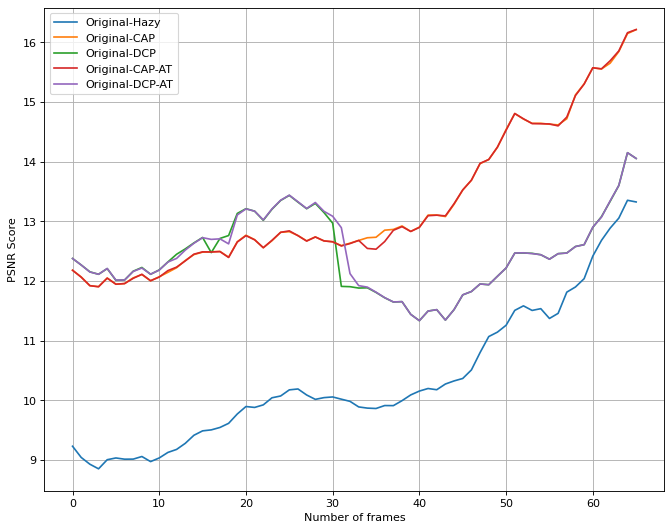

In [9]:
scores_1 = skvideo.measure.psnr(ref_vid_gray, haz_vid_gray)
scores_2 = skvideo.measure.psnr(ref_vid_gray, dis_cap_vid_gray)
scores_3 = skvideo.measure.psnr(ref_vid_gray, dis_dcp_vid_gray)
scores_4 = skvideo.measure.psnr(ref_vid_gray, dis_cap_atm_vid_gray)
scores_5 = skvideo.measure.psnr(ref_vid_gray, dis_dcp_atm_vid_gray)

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(range(len(scores_1)),scores_1)
plt.plot(range(len(scores_2)),scores_2)
plt.plot(range(len(scores_3)),scores_3)
plt.plot(range(len(scores_4)),scores_4)
plt.plot(range(len(scores_5)),scores_5)

plt.legend(['Original-Hazy','Original-CAP', 'Original-DCP', 'Original-CAP-AT', 'Original-DCP-AT'], loc='upper left')
plt.xlabel('Number of frames')
plt.ylabel('PSNR Score')
plt.grid()
# plt.savefig('../outputs/compare_methods_var_noise_estimation.png')
plt.show()

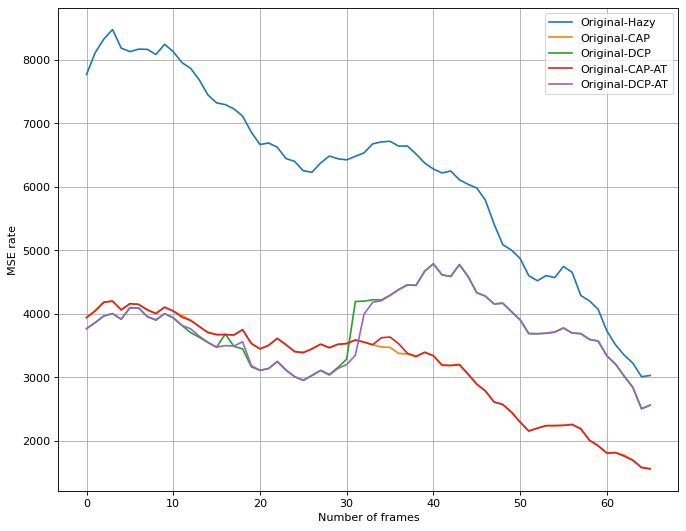

In [10]:
scores_1 = skvideo.measure.mse(ref_vid_gray, haz_vid_gray)
scores_2 = skvideo.measure.mse(ref_vid_gray, dis_cap_vid_gray)
scores_3 = skvideo.measure.mse(ref_vid_gray, dis_dcp_vid_gray)
scores_4 = skvideo.measure.mse(ref_vid_gray, dis_cap_atm_vid_gray)
scores_5 = skvideo.measure.mse(ref_vid_gray, dis_dcp_atm_vid_gray)

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(range(len(scores_1)),scores_1)
plt.plot(range(len(scores_2)),scores_2)
plt.plot(range(len(scores_3)),scores_3)
plt.plot(range(len(scores_4)),scores_4)
plt.plot(range(len(scores_5)),scores_5)

plt.legend(['Original-Hazy','Original-CAP', 'Original-DCP', 'Original-CAP-AT', 'Original-DCP-AT'], loc='upper right')
plt.xlabel('Number of frames')
plt.ylabel('MSE rate')
plt.grid()
# plt.savefig('../outputs/compare_methods_var_noise_estimation.png')
plt.show()

In [11]:
ref_vid_y = convert_luminance(ref_vid)
haz_vid_y = convert_luminance(haz_vid)
dis_cap_vid_y = convert_luminance(dis_cap_vid)
dis_dcp_vid_y = convert_luminance(dis_dcp_vid)
dis_cap_atm_vid_y = convert_luminance(dis_cap_atm_vid)
dis_dcp_atm_vid_y = convert_luminance(dis_dcp_atm_vid)

In [12]:
def compute_ssim(ref_vid, dis_vid):
    T, M, N, C = ref_vid.shape
    ssim_scores = np.zeros(T, dtype=np.float32)
    for i in range(T):
        ref_frame = ref_vid[i,:,:,0]
        dis_frame = dis_vid[i,:,:,0]
        ssim_score = ssim(ref_frame, dis_frame)
        ssim_scores[i] = ssim_score
    return ssim_scores

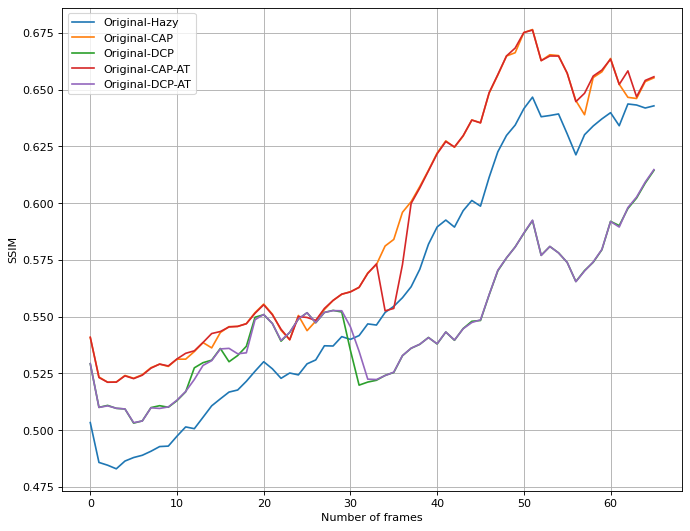

In [13]:
scores_1 = compute_ssim(ref_vid_y, haz_vid_y)
scores_2 = compute_ssim(ref_vid_y, dis_cap_vid_y)
scores_3 = compute_ssim(ref_vid_y, dis_dcp_vid_y)
scores_4 = compute_ssim(ref_vid_y, dis_cap_atm_vid_y)
scores_5 = compute_ssim(ref_vid_y, dis_dcp_atm_vid_y)

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(range(len(scores_1)),scores_1)
plt.plot(range(len(scores_2)),scores_2)
plt.plot(range(len(scores_3)),scores_3)
plt.plot(range(len(scores_4)),scores_4)
plt.plot(range(len(scores_5)),scores_5)

plt.legend(['Original-Hazy','Original-CAP', 'Original-DCP', 'Original-CAP-AT', 'Original-DCP-AT'], loc='upper left')
plt.xlabel('Number of frames')
plt.ylabel('SSIM')
plt.grid()
# plt.savefig('../outputs/compare_methods_var_noise_estimation.png')
plt.show()

In [14]:
ref_vid_gray.shape

(66, 850, 1280, 1)

In [15]:
scores_1 = skvideo.measure.strred(ref_vid_gray, haz_vid_gray)
scores_2 = skvideo.measure.strred(ref_vid_gray, dis_cap_vid_gray)
scores_3 = skvideo.measure.strred(ref_vid_gray, dis_dcp_vid_gray)
scores_4 = skvideo.measure.strred(ref_vid_gray, dis_cap_atm_vid_gray)
scores_5 = skvideo.measure.strred(ref_vid_gray, dis_dcp_atm_vid_gray)

In [16]:
scores_0 = skvideo.measure.strred(ref_vid_gray, ref_vid_gray)

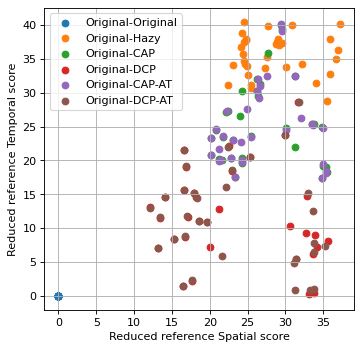

In [17]:
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(scores_0[0][:,2],scores_0[0][:,3])
plt.scatter(scores_1[0][:,2],scores_1[0][:,3])
plt.scatter(scores_2[0][:,2],scores_2[0][:,3])
plt.scatter(scores_3[0][:,2],scores_3[0][:,3])
plt.scatter(scores_4[0][:,2],scores_4[0][:,3])
plt.scatter(scores_5[0][:,2],scores_5[0][:,3])

plt.legend(['Original-Original', 'Original-Hazy','Original-CAP', 'Original-DCP', 'Original-CAP-AT', 'Original-DCP-AT'], loc='upper left')
plt.xlabel('Reduced reference Spatial score')
plt.ylabel('Reduced reference Temporal score')
plt.grid()
# plt.savefig('../outputs/compare_methods_var_noise_estimation.png')
plt.show()

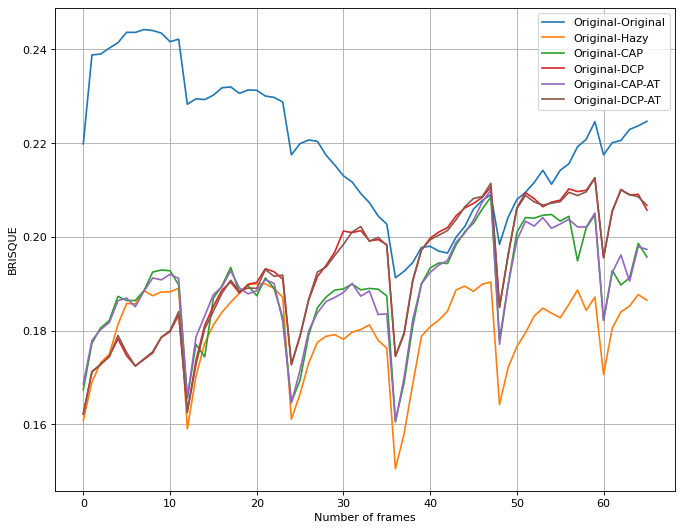

In [61]:
scores_0 = brisque_features(ref_vid_gray)
scores_1 = brisque_features(haz_vid_gray)
scores_2 = brisque_features(dis_cap_vid_gray)
scores_3 = brisque_features(dis_dcp_vid_gray)
scores_4 = brisque_features(dis_cap_atm_vid_gray)
scores_5 = brisque_features(dis_dcp_atm_vid_gray)
plt.figure(figsize=(10, 8), dpi=80)
plt.plot(range(len(scores_0)),np.mean(scores_0, axis=1))
plt.plot(range(len(scores_1)),np.mean(scores_1, axis=1))
plt.plot(range(len(scores_2)),np.mean(scores_2, axis=1))
plt.plot(range(len(scores_3)),np.mean(scores_3, axis=1))
plt.plot(range(len(scores_4)),np.mean(scores_4, axis=1))
plt.plot(range(len(scores_5)),np.mean(scores_5, axis=1))

plt.legend(['Original-Original', 'Original-Hazy','Original-CAP', 'Original-DCP', 'Original-CAP-AT', 'Original-DCP-AT'], loc='upper right')
plt.xlabel('Number of frames')
plt.ylabel('BRISQUE')
plt.grid()
# plt.savefig('../outputs/compare_methods_var_noise_estimation.png')
plt.show()

In [68]:
# scores_0 = skvideo.measure.videobliinds_features(ref_vid_gray)
# scores_1 = skvideo.measure.videobliinds_features(haz_vid_gray)
# scores_2 = skvideo.measure.videobliinds_features(dis_cap_vid_gray)
# scores_3 = skvideo.measure.videobliinds_features(dis_dcp_vid_gray)
# scores_4 = skvideo.measure.videobliinds_features(dis_cap_atm_vid_gray)
# scores_5 = skvideo.measure.videobliinds_features(dis_dcp_atm_vid_gray)

In [69]:
# plt.figure(figsize=(10, 8), dpi=80)
# plt.plot(range(len(scores_0)),np.mean(scores_0, axis=1))
# plt.plot(range(len(scores_1)),np.mean(scores_1, axis=1))
# plt.plot(range(len(scores_2)),np.mean(scores_2, axis=1))
# plt.plot(range(len(scores_3)),np.mean(scores_3, axis=1))
# plt.plot(range(len(scores_4)),np.mean(scores_4, axis=1))
# plt.plot(range(len(scores_5)),np.mean(scores_5, axis=1))

# plt.legend(['Original-Original', 'Original-Hazy','Original-CAP', 'Original-DCP', 'Original-CAP-AT', 'Original-DCP-AT'], loc='upper right')
# plt.xlabel('Number of frames')
# plt.ylabel('BRISQUE')
# plt.grid()
# # plt.savefig('../outputs/compare_methods_var_noise_estimation.png')
# plt.show()